2024-11-17 20:49:10.083470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 20:49:10.802994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0, Loss: 1.0578736066818237
Epoch 1000, Loss: 0.0004737475246656686
Epoch 2000, Loss: 0.00013604428386315703
Epoch 3000, Loss: 7.690447819186375e-05
Epoch 4000, Loss: 7.671386265428737e-05
Epoch 5000, Loss: 2.849387783498969e-05
Epoch 6000, Loss: 1.3016540833632462e-05
Epoch 7000, Loss: 5.1472916311468e-06
Epoch 8000, Loss: 3.1430661238118773e-06
Epoch 9000, Loss: 2.673888729987084e-06


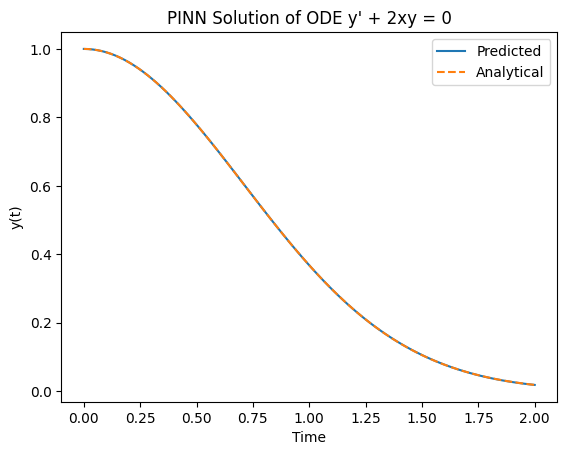

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t):
        x = self.hidden1(t)
        x = self.hidden2(x)
        return self.output_layer(x)

# Define the ODE residual (y' + 2xy = 0)
def residual(model, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        y = model(t)
        dy_dt = tape.gradient(y, t)
    # Residual of the differential equation
    return dy_dt + 2 * t * y

# Training data
t = np.linspace(0, 2, 100).reshape(-1, 1)  # Time points from 0 to 2
y0 = np.array([[1.0]])  # Initial condition for y(0)

# Convert numpy arrays to tensors
t = tf.convert_to_tensor(t, dtype=tf.float32)
y0 = tf.convert_to_tensor(y0, dtype=tf.float32)

# Define the model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
for epoch in range(10000):
    with tf.GradientTape() as tape:
        # Compute the loss (residuals + initial conditions)
        loss_residual = tf.reduce_mean(tf.square(residual(model, t)))
        loss_initial = tf.reduce_mean(tf.square(model(tf.zeros((1, 1), dtype=tf.float32)) - y0))
        loss = loss_residual + loss_initial

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Predict and plot the solution
t_test = np.linspace(0, 2, 100).reshape(-1, 1).astype(np.float32)
y_pred = model(t_test).numpy()

# Analytical solution for comparison (y = exp(-x^2))
y_analytical = np.exp(-t_test**2)

plt.plot(t_test, y_pred, label='Predicted')
plt.plot(t_test, y_analytical, label='Analytical', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('''PINN Solution of ODE y' + 2xy = 0''')
plt.legend()
plt.show()

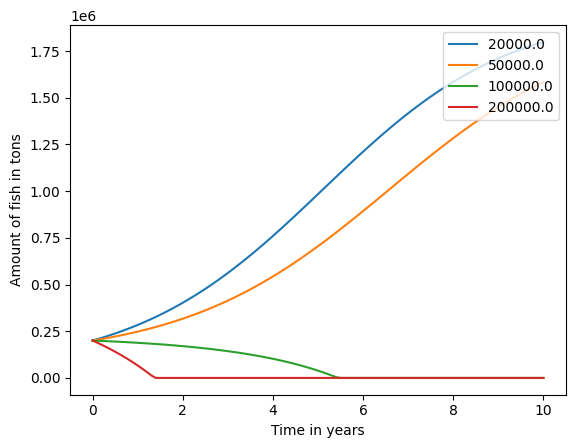

In [12]:
import matplotlib.pyplot
import numpy

harvest_rates = [2e4, 5e4, 1e5, 2e5] # tons / year

# This is used to keep track of the data that we want to plot.
data = []

def logistic_growth():
    maximum_growth_rate = 0.5 # 1 / year
    carrying_capacity = 2e6 # tons

    end_time = 10. # years
    h = 0.1 # years
    num_steps = int(end_time / h)
    times = h * numpy.array(range(num_steps + 1))

    fish = numpy.zeros(num_steps + 1) # tons
    fish[0] = 2e5

    for harvest_rate in harvest_rates:
        is_extinct = False

        for step in range(num_steps):
            if is_extinct:
                fish_next_step = 0.
            else:
                fish_next_step = fish[step] + h*(maximum_growth_rate*(1.-(fish[step]/carrying_capacity))*fish[step] - harvest_rate)
                if fish_next_step <= 0.:
                    is_extinct = True
                    fish_next_step = 0.
            fish[step+1] = fish_next_step
            
        data.append(([time for time in times], [f for f in fish], 
            str(harvest_rate)))

    return fish

fish = logistic_growth()


def plot_me():
    fish_plots = []
    for (times, fish, rate_label) in data:
        fish_plots.append(matplotlib.pyplot.plot(times, fish, label=rate_label))    
    matplotlib.pyplot.legend([str(rate) for rate in harvest_rates], loc='upper right')
    axes = matplotlib.pyplot.gca()
    axes.set_xlabel('Time in years')
    axes.set_ylabel('Amount of fish in tons')
    matplotlib.pyplot.show()

plot_me()

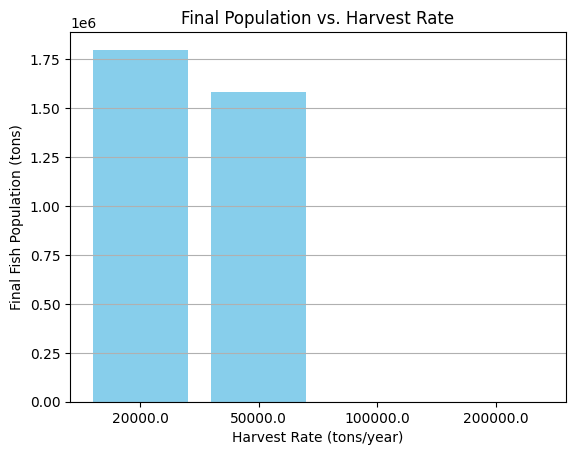

In [14]:
# Harvest Rate vs. Final Population
final_populations = [fish[-1] for _, fish, _ in data]

matplotlib.pyplot.figure()
matplotlib.pyplot.bar([str(rate) for rate in harvest_rates], final_populations, color='skyblue')
matplotlib.pyplot.xlabel('Harvest Rate (tons/year)')
matplotlib.pyplot.ylabel('Final Fish Population (tons)')
matplotlib.pyplot.title('Final Population vs. Harvest Rate')
matplotlib.pyplot.grid(axis='y')
matplotlib.pyplot.show()


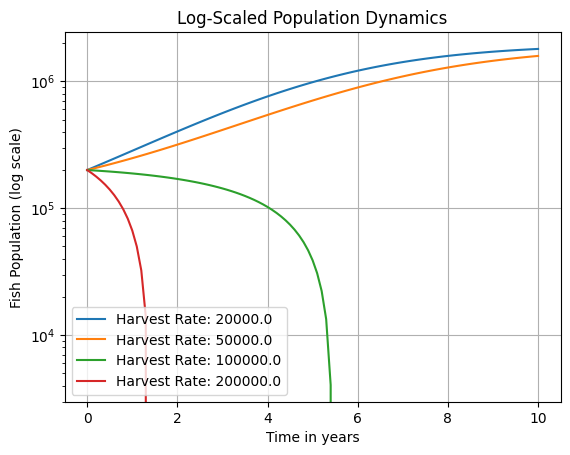

In [15]:
# Logarithmic Fish Population Dynamics
matplotlib.pyplot.figure()
for times, fish, rate_label in data:
    matplotlib.pyplot.plot(times, fish, label=f'Harvest Rate: {rate_label}')
matplotlib.pyplot.yscale('log')
matplotlib.pyplot.xlabel('Time in years')
matplotlib.pyplot.ylabel('Fish Population (log scale)')
matplotlib.pyplot.legend(loc='lower left')
matplotlib.pyplot.title('Log-Scaled Population Dynamics')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()


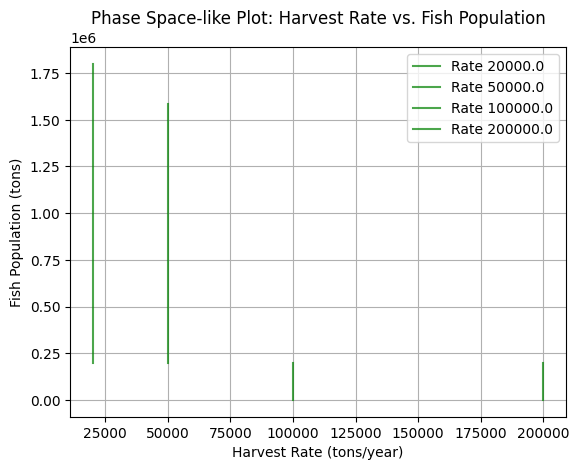

In [19]:
import matplotlib.pyplot as plt

# Reusing data from the logistic growth problem
# Assuming `data` contains results for logistic growth as defined in the original code
# Extract a phase space-like visualization using fish population and harvest rates

# Phase space-like plot: Population vs. Harvest Rate
plt.figure()

# Assuming the last recorded population corresponds to the state to plot against harvest rate
for _, fish, rate_label in data:
    plt.plot([float(rate_label)] * len(fish), fish, 'g-', alpha=0.7, label=f'Rate {rate_label}')

plt.xlabel("Harvest Rate (tons/year)")
plt.ylabel("Fish Population (tons)")
plt.title("Phase Space-like Plot: Harvest Rate vs. Fish Population")
plt.grid(True)
plt.legend()
plt.show()


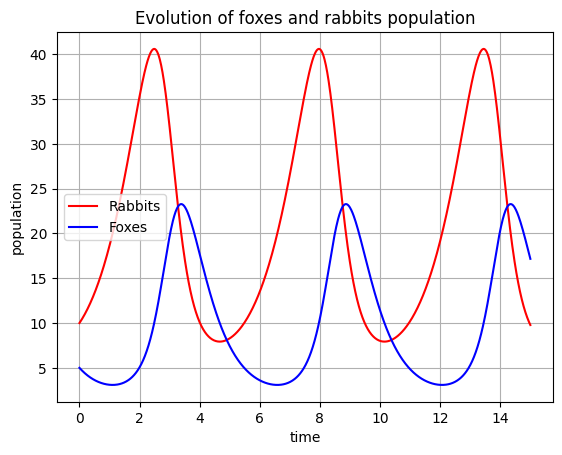

In [20]:
from numpy import *
from scipy import integrate
import pylab as p

# Define parameters defining the behavior of the population
# Case: fox is predator, rabbit is prey
a = 1.      # a is the natural growing rate of rabbits, when there's no fox
b = 0.1     # b is the natural dying rate of rabbits, due to predation
c = 1.5     # c is the natural dying rate of fox, when there's no rabbit
d = 0.75    # d is the factor describing how many caught rabbits let create a new fox

def dX_dt(X, t=0):
    """Return the growth rate of predator and prey population"""
    return array([a*X[0] - b*X[1]*X[0],
                  -c*X[1] + d*b*X[1]*X[0]])

t = linspace(0, 15, 1000)   # time until 1000 days, with 15 days interval
X0 = array([10, 5])         # initial population (rabbit, fox)
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']         # integration successful

rabbits, foxes = X.T
f1 = p.figure()
p.plot(t, rabbits, 'r-', label='Rabbits')
p.plot(t, foxes, 'b-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of foxes and rabbits population')
f1.savefig('rabbits_foxes.png')

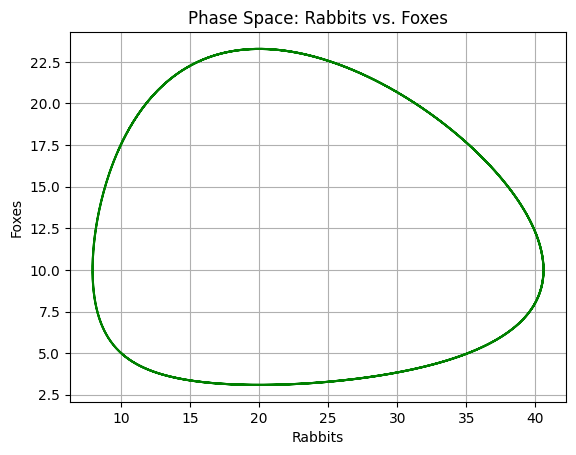

In [6]:
# Phase space plot (Rabbits vs. Foxes)
f2 = p.figure()
p.plot(rabbits, foxes, 'g-')
p.grid()
p.xlabel('Rabbits')
p.ylabel('Foxes')
p.title('Phase Space: Rabbits vs. Foxes')
f2.savefig('phase_space.png')


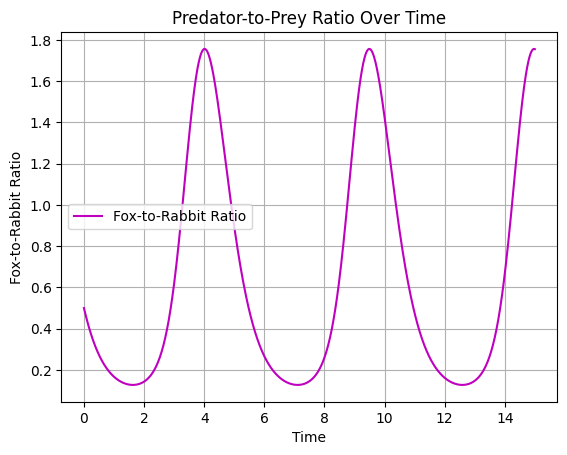

In [7]:
# Predator-to-Prey Ratio over Time
ratio = foxes / rabbits
f3 = p.figure()
p.plot(t, ratio, 'm-', label='Fox-to-Rabbit Ratio')
p.grid()
p.legend(loc='best')
p.xlabel('Time')
p.ylabel('Fox-to-Rabbit Ratio')
p.title('Predator-to-Prey Ratio Over Time')
f3.savefig('predator_prey_ratio.png')
